In [1]:
import matplotlib.pyplot as plt
import numpy as np
import dsdl
import numpy.random
from typing import Callable, List
import pandas as pd
import json
import os

%load_ext autoreload
%autoreload 2
from src.regression.reg import LossType

# Logistic regression

In [30]:
from optimizers.Optimizer import Optimizer

In [31]:
DATA_DIR = 'data/'

def get_data(dataset_filename: str):
    """
    Loads dataset from csv file. The last column must represent the target variable.
    :param dataset_filename: Filename of the dataset from dsdl module.
    :return: (X, y) feature and target data.
    """
    filepath = os.path.join(DATA_DIR, dataset_filename)
    df = pd.read_csv(filepath)
    return df.iloc[:,:-1].values, df.iloc[:,-1].values.reshape(-1, 1)

def build_model(X, y):
    """
    Joins weights
    :param X: shape=(N, D). Train data
    :param y: shape=(N, 1). Target data
    :return: shape=(N, D+1). Built model for logistic regression.
    """
    return np.c_[np.zeros((y.shape[0], 1)), X]

def get_initial_weights(tx):
    """
    Returns weights initialized from the uniform distribution [0, 1].
    :param tx: shape=(N, D). Build model
    :return: shape=(D, 1) Initial weights
    """
    np.random.seed(2022)
    return np.zeros(shape=(tx.shape[1], 1))

def test_method(method: Optimizer,
                initial_weights,
                tx,
                y,
                max_iter: int,
                loss_type,
                *parameter):
        """
        :param method: Optimization method implementation from src optimizers module.
        :param dataset_name: Name of the dataset from dsdl module.
        :param max_iter: Number of iterations to test.
        :param parameters optional: Dataclass containing parameters used int optimization method.
        :return: List of gradients from optimization method.
        """
        gradients, loss = method.optimize(initial_weights, tx, y, max_iter, loss_type)
        return [np.linalg.norm(grad, 2) for grad in gradients], loss

In [32]:
from optimizers.SGD import SGD
from optimizers.AdaGrad import AdaGrad

In [33]:
N_ORACLE_CALLS = 10

DATASETS = ['diabetes.csv']#, 'housing.csv']
LOSS_TYPES = [LossType.MAE] #, LossType.MSE]


METHODS = [
    AdaGrad(lambda_=0.0001, epsilon= 0.0001, q=N_ORACLE_CALLS),
    SGD(lambda_=0.0001, q=N_ORACLE_CALLS)
]

## Run simulations

In [35]:
ITERATIONS = 100000
N_RUNS = 1

all_gradients = []

datasets_data = {}
for i, dataset_name in enumerate(DATASETS):

    print("Dataset", dataset_name)

    X, y = get_data(dataset_name)
    tx = build_model(X, y)
    initial_weights = get_initial_weights(tx)

    methods_data = {}
    for method in METHODS:
        for loss_type in LOSS_TYPES:
            print("Method: ", method.name, ", loss: ", loss_type)

            gradients_5_runs = list()
            for _ in range(N_RUNS):
                gradients, _ = test_method(method, initial_weights, tx, y, ITERATIONS, loss_type)
                gradients_5_runs.append(gradients)
            gradients_mean = np.mean(gradients_5_runs, axis=0)

            stddev = np.std(gradients_5_runs, axis=0)
            lower = gradients_mean - stddev
            upper = gradients_mean + stddev

            methods_data[method.name] = {
                "gradient_mean": list(gradients_mean),
                "lower": lower,
                "upper": upper,
                "n_runs": N_RUNS,
                "n_iterations": ITERATIONS
            }
            datasets_data[dataset_name] = methods_data


print("DONE")

Dataset diabetes.csv
Method:  AdaGrad , loss:  LossType.MAE
0 70.62589131877847
10000 21.950835921137813
20000 -9.954441816754342
30000 -38.76900436896043
40000 97.01996159646119
50000 -15.137714660541207
60000 46.23763857656224
70000 -149.45859507205557
80000 71.2459964317761
90000 -182.7453251149073
Method:  SGD , loss:  LossType.MAE
0 105.7580492774215
10000 2.0660979964728523
20000 116.11858395716418
30000 16.843317387481516
40000 -17.704088808672537
50000 -7.5644024264669545
60000 -6.14988480900999
70000 -59.245747413884004
80000 -176.89341446305977
90000 -35.163414938060065
DONE


In [36]:
methods_colors = {
    "SGD": "blue",
    "AdaGrad": "purple",
    "AdaSpider": "orange",
    "Spider": "green",
    "SpiderBoost": "red",
    "SVRG": "brown",
    "AdaSVRG": "pink"
}

In [37]:
np.std(methods_data['AdaGrad']['gradient_mean'])

305.5761641597296

Dataset diabetes.csv
Method AdaGrad
10000
Method SGD
10000


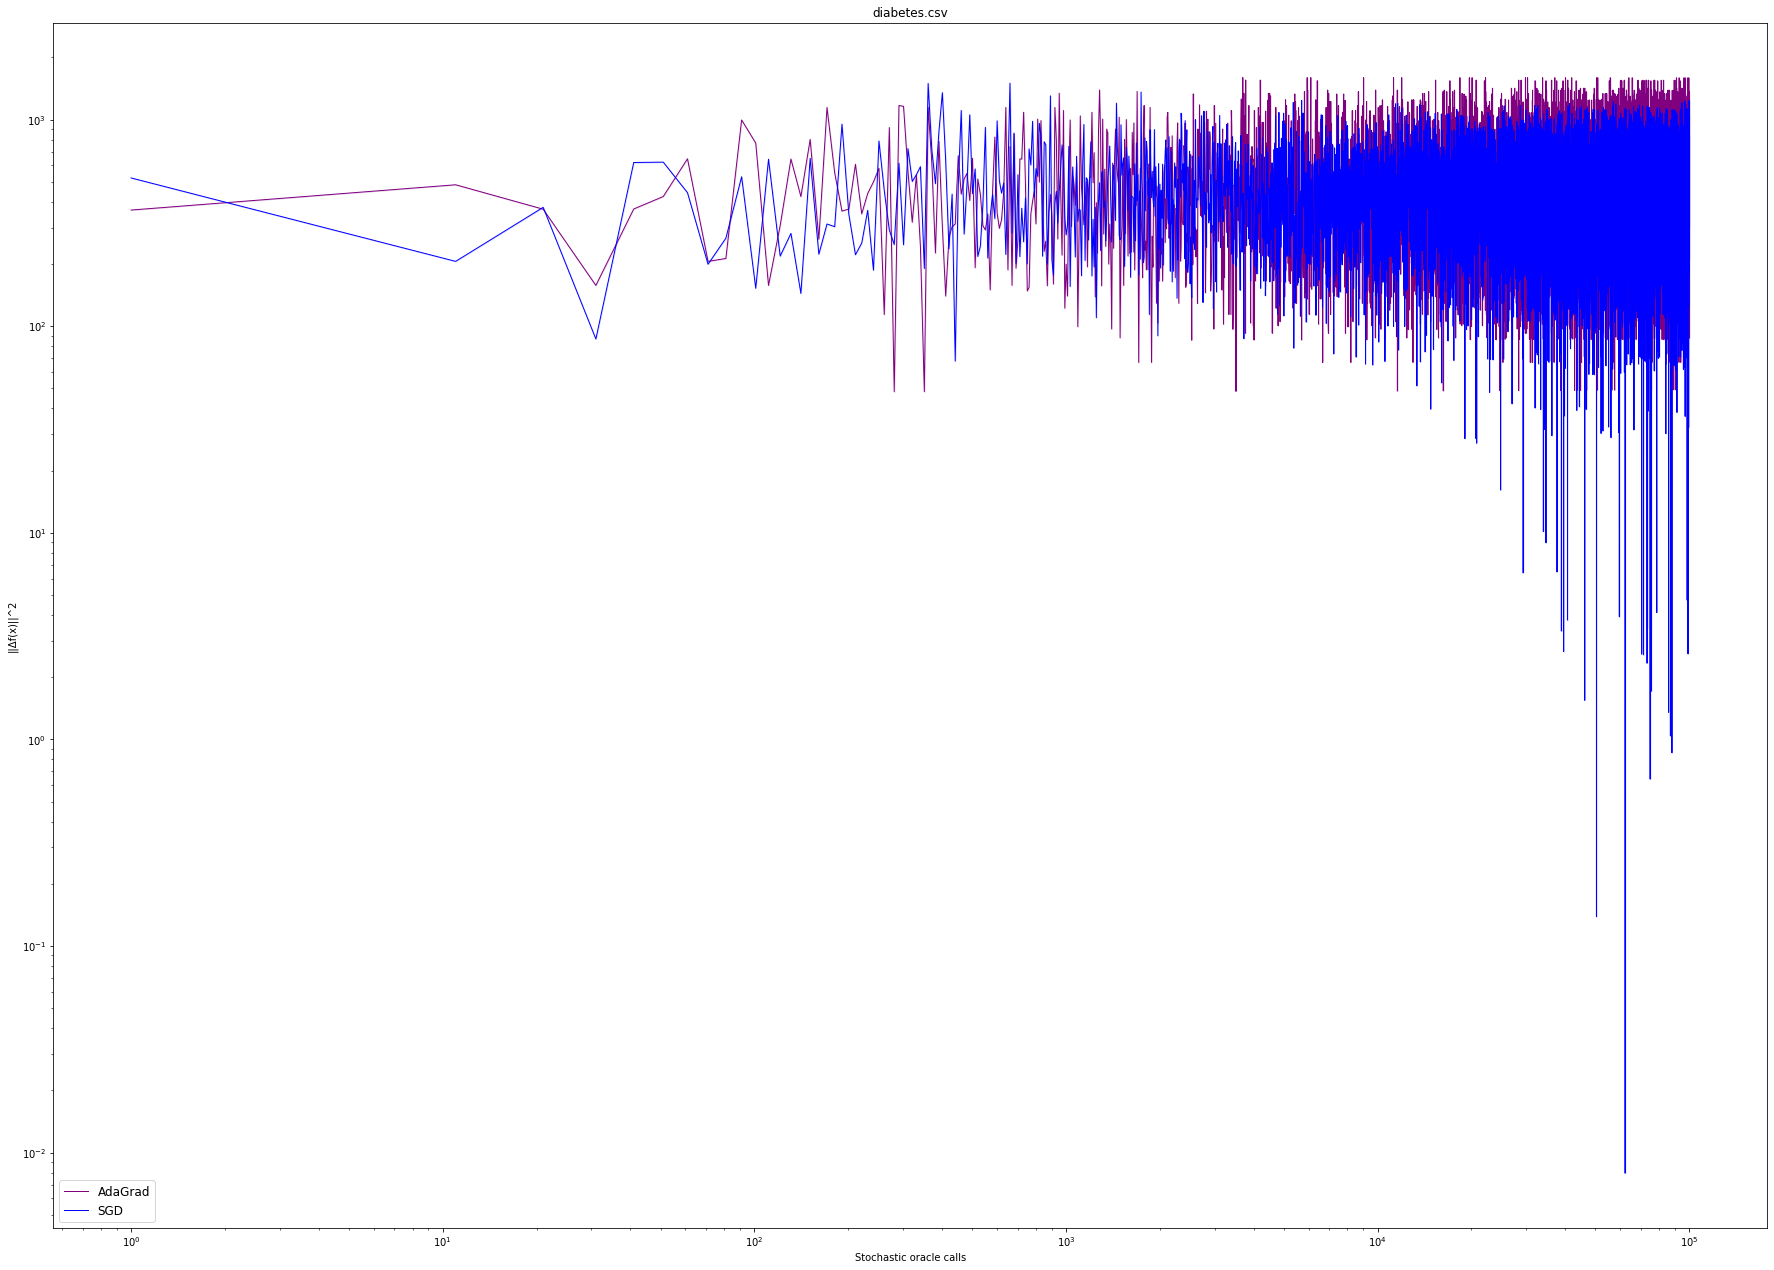

In [38]:
X_LABEL = "Stochastic oracle calls"
Y_LABEL = "||\u0394f(x)||^2"

fig, ax = plt.subplots(1, 1, figsize=(25, 18), sharey=False, sharex=False)  # 3, 2

for i, dataset_name in enumerate(DATASETS):
    print("Dataset", dataset_name)

    methods_data = datasets_data[dataset_name]

    # sbplt = ax[i%3, i%2]
    sbplt = ax

    for method_name, method_data in methods_data.items():
        print("Method", method_name)

        method_color = methods_colors[method_name]
        gradients_mean = method_data['gradient_mean']
        lower = method_data['lower']
        upper = method_data['upper']
        n_iterations = method_data['n_iterations']
        gradient_calls = 0

        if gradient_calls != 0:
            grad_x = [(gradient_calls*n)+1 for n in range(len(gradients_mean))]
        else:
            EACH = 10
            gradients_mean = gradients_mean[0::EACH]
            lower = lower[0::EACH]
            upper = upper[0::EACH]

            grad_x = [(EACH*n)+1 for n in range(len(gradients_mean))]
        print(len(grad_x))
        sbplt.plot(grad_x, gradients_mean, label=method_name,
                   linewidth=1, color=method_color)

        sbplt.fill_between(grad_x, lower, upper, alpha=0.12,
                           facecolor=method_color, edgecolor=method_color)

    sbplt.set_xscale('log')
    sbplt.set_yscale('log')
    sbplt.set_title(dataset_name)
    sbplt.set_xlabel(X_LABEL)
    sbplt.set_ylabel(Y_LABEL)
    sbplt.legend(loc='lower left', fontsize='large')

fig.tight_layout(pad=2.0)

In [ ]:
for key, val in datasets_data['diabetes.csv'].items():
    datasets_data['diabetes.csv'][key]['gradient_mean'] = list(val['gradient_mean'])
    datasets_data['a1a'][key]['lower'] = list(val['lower'])
    datasets_data['a1a'][key]['upper'] = list(val['upper'])

In [ ]:
with open('parameters_sweep_3.json', 'w') as file:
    json.dump(datasets_data, file)

In [ ]:
# get the mean length of gradients
print("DONE")
min_length = None
for key, val in datasets_data['a1a'].items():
    current_length = len(val['gradient_mean'])
    if min_length is None:
        min_length = current_length
    elif min_length > current_length:
        min_length = current_length
min_length

### Plot

In [ ]:
X_LABEL = "Stochastic oracle calls"
Y_LABEL = "||\u0394f(x)||^2"

fig, ax = plt.subplots(1, 1, figsize=(25, 18), sharey=False, sharex=False)  # 3, 2

for i, dataset_name in enumerate(DATASETS):
    print("Dataset", dataset_name)

    methods_data = datasets_data[dataset_name]

    # sbplt = ax[i%3, i%2]
    sbplt = ax

    for method_name, method_data in methods_data.items():
        print("Method", method_name)

        gradients_mean = method_data['gradient_mean']
        lower = method_data['lower']
        upper = method_data['upper']
        n_iterations = method_data['n_iterations']

        sbplt.plot(gradients_mean[:min_length], label=method_name)
        sbplt.fill_between(list(range(len(gradients_mean[:min_length]))), lower[:min_length], upper[:min_length], alpha=0.25,
                           facecolor='red', edgecolor='red')

    sbplt.set_xscale('log')
    sbplt.set_yscale('log')
    sbplt.set_title(dataset_name)
    sbplt.set_xlabel(X_LABEL)
    sbplt.set_ylabel(Y_LABEL)
    sbplt.legend(loc='lower left', fontsize='large')

    break  # plot single dataset

fig.tight_layout(pad=2.0)
# fig.savefig(f'tests_logistic_regression_zeros_parameters_sweep_1_fixed_methods.jpg', dpi=300)

# plot_data()

In [43]:
print('open')

open


Do parameter sweep

In [49]:
from itertools import product

In [50]:
REDUCTION_STEP = 1000

METHODS = [
    SGD(lambda_=0.01, q=REDUCTION_STEP),
    # AdaSpider(q=REDUCTION_STEP),
    Spider(n_0 = 1, epsilon=0.01, q=REDUCTION_STEP),
    SpiderBoost(q=REDUCTION_STEP),
    SVRG(lambda_=0.001, q=REDUCTION_STEP),
    AdaGrad(lambda_=0.5, epsilon= 0.00001, q=REDUCTION_STEP),
    AdaSVRG(lambda_=0.1, q=REDUCTION_STEP)
]

DF_COLUMNS = ['method_name', 'loss', 'parameters']
df = pd.DataFrame(columns=DF_COLUMNS)

dataset_name = 'a1a'
ITERATIONS = 5000
print("Dataset", dataset_name, "Iterations: ", ITERATIONS)

powers = np.array([range(-5, 0)], dtype=float)
parameters = 10**powers.flatten()

X, y = get_data(dataset_name)
tx = build_model(X, y)
initial_weights = get_initial_weights(tx)

for method in METHODS:
    print("Method", method.name)
    if method.n_params_to_tune == 2:
        for param in list(product(parameters, parameters)):
            method.set_params(param[0], param[1])
            _, losses = test_method(method, initial_weights, tx, y, ITERATIONS)
            df = df.append(dict(zip(DF_COLUMNS, [method.name, np.sum(losses), str(param)])), ignore_index=True)

    elif method.n_params_to_tune == 1:
        for param in parameters:
            method.set_params(param)
            _, losses = test_method(method, initial_weights, tx, y, ITERATIONS)
            df = df.append(dict(zip(DF_COLUMNS, [method.name, np.sum(losses), str(param)])), ignore_index=True)
    else:
        _, losses = test_method(method, initial_weights, tx, y, ITERATIONS)
        df = df.append(dict(zip(DF_COLUMNS, [method.name, np.sum(losses), str(param)])), ignore_index=True)

Dataset a1a Iterations:  5000
Method SGD


C:\Users\PB\Documents\GithubRepos\EPFL\ML-reproducibility-challenge\src\logistic_regression\sigmoid.py:6: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-t))


Method Spider
Method SpiderBoost
Method SVRG
Method AdaGrad


C:\Users\PB\Documents\GithubRepos\EPFL\ML-reproducibility-challenge\src\logistic_regression\log_reg.py:41: RuntimeWarning: overflow encountered in exp
  first_component = np.log(1 + np.exp(tx.dot(w)))


Method AdaSVRG


In [52]:
df.to_csv("parameters_sweep_2.csv", index=False)

In [53]:
df['loss'] = df['loss'].abs()
df.groupby('method_name').min()

,loss,parameters
method_name,,
AdaGrad,3432.160706,"(0.0001, 0.0001)"
AdaSVRG,851480.257577,0.0001
SGD,902.078086,0.0001
SVRG,1148.117316,0.0001
Spider,2270.080086,"(0.0001, 0.0001)"
SpiderBoost,2203.122416,"(0.1, 0.1)"


In [65]:
# METHODS = ['AdaSpider', 'Spider']
# ITERATIONS = 100
#
# def plot_data():
#     # Write your code to make 4x4 panel here
#     X_LABEL = "Stochastic oracle calls"
#     Y_LABEL = "||\u0394f(x)||^2"
#
#     fig, ax = plt.subplots(3,2,figsize=(16,16), sharey=False, sharex=False)
#
#     for i, dataset_name in enumerate(DATASETS):
#         sbplt = ax[i%3, i%2]
#         print(dataset_name)
#         for method in METHODS:
#             if method == "Spider":
#                 spider_params = SpiderParam(100, 5, 0.05)
#                 gradients = test_method(Spider, dataset_name, ITERATIONS, spider_params)
#             else:
#                 gradients = test_method(ADASpider, dataset_name, ITERATIONS)
#             gradients = [np.linalg.norm(grad, 2) for grad in gradients]
#             sbplt.plot(gradients, label=method)
#
#         sbplt.set_xscale('log')
#         sbplt.set_title(dataset_name)
#         sbplt.set_xlabel(X_LABEL)
#         sbplt.set_ylabel(Y_LABEL)
#         sbplt.legend(loc='lower left')
#
#         break  # plot single dataset
#
#     fig.tight_layout(pad=2.0)
#     # fig.savefig('tests_logistic_regression.jpg', dpi=150)
#
# plot_data()